In [23]:
import matplotlib.pyplot as plt
import random
import copy
import operator

In [24]:
# parámetros
T = [0, 1, 4]
n = 100
ngen = 100
prob_cruza = 0.9
prob_muta = 0.1
max_p = 8
max_nn = 256
k = 3
n_exps = 10

In [25]:
def subarbol(p, funciones):
    if p == 0:
        return random.choice(T)
    op = random.choice(list(funciones.keys()))
    return [op,
            subarbol(p-1, funciones),
            subarbol(p-1, funciones)]

def arbol(funciones):
    d = random.randint(1, max_p)
    return subarbol(d, funciones)

In [26]:
def contador(arbol):
    if not isinstance(arbol, list):
        return 1
    return 1 + contador(arbol[1]) + contador(arbol[2])

def eval_arbol(arbol, funciones):
    if not isinstance(arbol, list):
        return arbol
    l = eval_arbol(arbol[1], funciones)
    r = eval_arbol(arbol[2], funciones)
    return funciones[arbol[0]](l, r)

In [27]:
def l_caminos(arbol):
    caminos = [[]]
    if isinstance(arbol, list):
        for idx, hijo in enumerate([arbol[1], arbol[2]], start=1):
            for sp in l_caminos(hijo):
                caminos.append([idx] + sp)
    return caminos

def get_subarbol(arbol, camino):
    if not camino:
        return arbol
    return get_subarbol(arbol[camino[0]], camino[1:])

def set_subarbol(arbol, camino, subarbol):
    if not camino:
        return subarbol
    if not isinstance(arbol, list):
        return arbol
    op = arbol[0]
    izq = arbol[1]
    der = arbol[2]
    if camino[0] == 1:
        izq = set_subarbol(izq, camino[1:], subarbol)
    else:
        der = set_subarbol(der, camino[1:], subarbol)
    return [op, izq, der]

In [28]:
class Individuo:
    def __init__(s, arbol):
        s.arbol = arbol
        s.error = None

    def evaluar(s, funciones):
        try:
            v = eval_arbol(s.arbol, funciones)
            s.error = abs(v - 10)
        except:
            s.error = float('inf')

In [29]:
def torneo(pop):
    sel = []
    for _ in range(n):
        lucha = random.sample(pop, k)
        gana   = min(lucha, key=lambda ind: ind.error)
        dupl    = copy.deepcopy(gana.arbol)
        ind      = Individuo(dupl)
        ind.error= gana.error
        sel.append(ind)
    return sel


In [30]:
def cruza(t1, t2, funciones):
    p1 = random.choice(l_caminos(t1))
    p2 = random.choice(l_caminos(t2))

    s1 = get_subarbol(t1, p1)
    s2 = get_subarbol(t2, p2)
    
    new1 = contador(t1) - contador(s1) + contador(s2)
    new2 = contador(t2) - contador(s2) + contador(s1)
    if new1 <= max_nn and new2 <= max_nn:
        return ( set_subarbol(t1, p1, copy.deepcopy(s2)),
                 set_subarbol(t2, p2, copy.deepcopy(s1)) )
    return t1, t2

In [31]:
def muta(arbol, funciones):
    camino = random.choice(l_caminos(arbol))
    d    = random.randint(0, 2)
    sub  = subarbol(d, funciones)
    old  = get_subarbol(arbol, camino)
    size = contador(arbol) - contador(old) + contador(sub)
    if size <= max_nn:
        return set_subarbol(arbol, camino, sub)
    return arbol

In [32]:
def GP(funciones):
    pop = [Individuo(arbol(funciones)) for _ in range(n)]
    for ind in pop: ind.evaluar(funciones)

    
    counts = {'0':[], '1':[], '4':[]}

    for gen in range(1, ngen+1):
        cnt = {k:0 for k in counts}

        for ind in pop:
            for camino in l_caminos(ind.arbol):
                node = get_subarbol(ind.arbol, camino)
                if not isinstance(node, list) and str(node) in cnt:
                    cnt[str(node)] += 1
        for k in cnt: counts[k].append(cnt[k])

        descendencia = torneo(pop)

        for i in range(0, n, 2):
            if random.random() < prob_cruza:
                c1, c2 = descendencia[i], descendencia[i+1]
                t1, t2 = cruza(c1.arbol, c2.arbol, funciones)
                c1.arbol, c2.arbol = t1, t2
                c1.error = c2.error = None

        for ind in descendencia:
            if random.random() < prob_muta:
                ind.arbol  = muta(ind.arbol, funciones)
                ind.error = None

        for ind in descendencia:
            if ind.error is None:
                ind.evaluar(funciones)

        pop = descendencia
    return counts

def  exps(funciones, label):
    all_counts = [GP(funciones)
                  for _ in range(n_exps)]
    
    min_counts = {'0':[], '1':[], '4':[]}
    for gen in range(ngen):
        for k in min_counts:
            vals = [counts[k][gen] for counts in all_counts]
            min_counts[k].append(min(vals))

    # 3) Grafica
    gens = list(range(1, ngen+1))
    plt.figure(figsize=(10,4))
    for k, vals in min_counts.items():
        plt.plot(gens, vals, label=f"Terminal {k}")
    plt.title(f"Cardinalidad mínima de T en {n_exps} experimentos — {label}")
    plt.xlabel("Generación")
    plt.ylabel("Población")
    plt.legend()
    plt.tight_layout()
    plt.show()





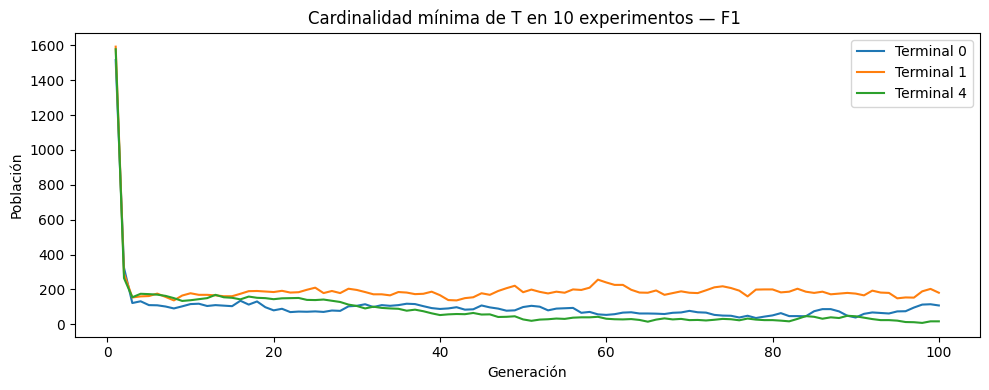

In [ ]:
if __name__ == "__main__":
    exps({'+': operator.add}, "F1 ")
    exps({'+': operator.add, '*': operator.mul}, "F2 ")